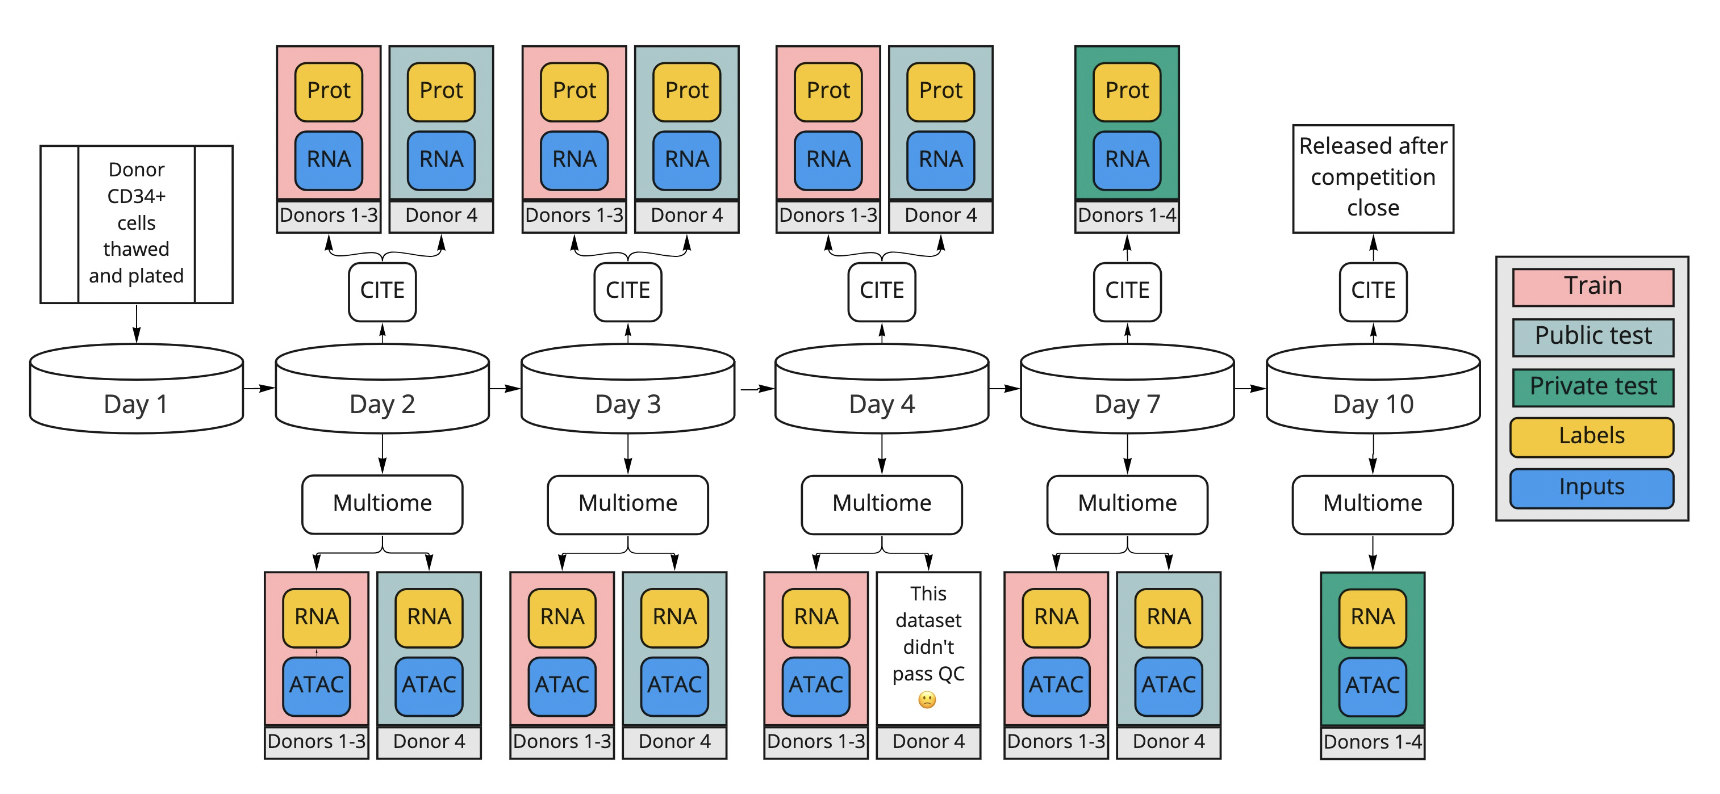

In [1]:
from IPython.display import Image
Image(filename='data.png') 

## Creating a good validation set

In [60]:
import pandas as pd
import numpy as np
import scipy.sparse
import random
import pickle

In [3]:
metadata = pd.read_csv('/arc/project/st-jiaruid-1/yinian/multiome/metadata.csv')

In [4]:
multi_ids = np.load('/arc/project/st-jiaruid-1/yinian/multiome/multi_ids.npy')

In [5]:
cite_ids = np.load('/arc/project/st-jiaruid-1/yinian/multiome/cite_ids.npy')

In [13]:
multi_val_set_ids = np.load('/arc/project/st-jiaruid-1/yinian/multiome/multi_val_set_10000_0.75_day_7.npy')
cite_val_set_ids = np.load('/arc/project/st-jiaruid-1/yinian/multiome/cite_val_set_5000_0.75_day_7.npy')

In [15]:
multi_val_set_ids

array(['bbffda0b60a7', '1234c6845572', '2b5a56d6eb87', ...,
       'cb73c15eb4d0', '1e285dc4b522', 'e2237fa3e8e4'], dtype='<U12')

In [14]:
len(multi_ids), len(cite_ids)

(105942, 70988)

In [20]:
metadata_ = metadata[
    metadata['cell_id'].isin(
        list(multi_ids) + list(cite_ids)
    )
]
metadata_ = metadata_[
    ~metadata['cell_id'].isin(
        list(multi_val_set_ids) + list(cite_val_set_ids)
    )
]

/scratch/st-jiaruid-1/shenoy/projects/scRNA-competition/notebooks/ipykernel_188898/3201044555.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  metadata_ = metadata_[


In [23]:
metadata_multi = metadata_[metadata_['technology'] == 'multiome'].reset_index(drop=True)
metadata_cite = metadata_[metadata_['technology'] == 'citeseq'].reset_index(drop=True)

In [24]:
metadata_multi.shape, metadata_cite.shape

((95943, 5), (65988, 5))

In [25]:
metadata_multi.head()

,cell_id,day,donor,cell_type,technology
0,56390cf1b95e,2,32606,NeuP,multiome
1,fc0c60183c33,2,32606,HSC,multiome
2,9b4a87e22ad0,2,32606,MasP,multiome
3,81cccad8cd81,2,32606,HSC,multiome
4,15cb3d85c232,2,32606,MkP,multiome


In [26]:
metadata_cite.head()

,cell_id,day,donor,cell_type,technology
0,45006fe3e4c8,2,32606,HSC,citeseq
1,d02759a80ba2,2,32606,HSC,citeseq
2,c016c6b0efa5,2,32606,EryP,citeseq
3,ba7f733a4f75,2,32606,NeuP,citeseq
4,fbcf2443ffb2,2,32606,EryP,citeseq


#### Distribution

In [32]:
# will fill crossval validation set based on a distribution, rest will go to train
# these are fractions
majority_multi = 0.7
majority_cite = 0.7
day_dist = {
    'multi': {
        'val': {
            7: majority_multi,
            4: (1 - majority_multi) / 3,
            3: (1 - majority_multi) / 3,
            2: (1 - majority_multi) / 3,    
        },
    },
    'cite': {
        'val': {
            4: majority_cite,
            3: (1 - majority_cite) / 2,
            2: (1 - majority_cite) / 2,                
        }
    }
}

#### For Multiome data

In [27]:
metadata_multi['day'].value_counts()

4    30301
3    27982
2    23078
7    14582
Name: day, dtype: int64

In [28]:
metadata_multi['donor'].value_counts()

31800    33416
13176    31963
32606    30564
Name: donor, dtype: int64

In [57]:
def get_splits(
    df,
    day_dist,
    modality='multi', # one of multi or cite
    val_frac=0.2,
    starting_seed=42,
    cv_splits = 5,
) -> dict:

    splits = {}

    train_frac = (1 - val_frac)

    # get length of cross val sets
    all_ids = df['cell_id'].tolist()
    all_ids_len = df.shape[0]
    val_ids_len = int(val_frac * all_ids_len)
    train_ids_len = int(train_frac * all_ids_len)

    for i in range(cv_splits):
        print (f'Working on split {i} with random seed {starting_seed + i}')
        random.seed(starting_seed + i)
        split = {}
        val_ids = []
        for day, frac in day_dist[modality]['val'].items():
            # get ids corresponding to that day
            ids_day = df[df['day'] == day]['cell_id'].tolist()
            # frac of val set length that should come from "day"
            n = int(val_ids_len * frac)
            print (f'For day: {day}, using {n} points')

            val_ids.extend(random.sample(ids_day, n))
            
        train_ids = df[~df['cell_id'].isin(val_ids)]['cell_id'].tolist()
        assert len(set(train_ids).intersection(set(val_ids))) == 0, 'intersection not 0, check it'
        splits = {
            f'cv_{i}': {
                'train': train_ids,
                'val': val_ids   
            }
        }

    return splits

In [62]:
modality = 'multi'
starting_seed = 42

splits = get_splits(metadata_multi, day_dist, modality=modality, starting_seed=starting_seed)

Working on split 0 with random seed 42
For day: 7, using 13431 points
For day: 4, using 1918 points
For day: 3, using 1918 points
For day: 2, using 1918 points
Working on split 1 with random seed 43
For day: 7, using 13431 points
For day: 4, using 1918 points
For day: 3, using 1918 points
For day: 2, using 1918 points
Working on split 2 with random seed 44
For day: 7, using 13431 points
For day: 4, using 1918 points
For day: 3, using 1918 points
For day: 2, using 1918 points
Working on split 3 with random seed 45
For day: 7, using 13431 points
For day: 4, using 1918 points
For day: 3, using 1918 points
For day: 2, using 1918 points
Working on split 4 with random seed 46
For day: 7, using 13431 points
For day: 4, using 1918 points
For day: 3, using 1918 points
For day: 2, using 1918 points


In [ ]:
file_name = f'cv_splits_{modality}_seed_{starting_seed}_majority_frac_{majority_multi}_rest_equiprobable'
with open(f'{file_name}.pkl', 'wb') as f:
    pickle.dump(splits, f)

#### Cite Data

In [63]:
modality = 'cite'
starting_seed = 42

splits = get_splits(metadata_cite, day_dist, modality=modality, starting_seed=starting_seed)

Working on split 0 with random seed 42
For day: 4, using 9237 points
For day: 3, using 1979 points
For day: 2, using 1979 points
Working on split 1 with random seed 43
For day: 4, using 9237 points
For day: 3, using 1979 points
For day: 2, using 1979 points
Working on split 2 with random seed 44
For day: 4, using 9237 points
For day: 3, using 1979 points
For day: 2, using 1979 points
Working on split 3 with random seed 45
For day: 4, using 9237 points
For day: 3, using 1979 points
For day: 2, using 1979 points
Working on split 4 with random seed 46
For day: 4, using 9237 points
For day: 3, using 1979 points
For day: 2, using 1979 points


In [64]:
file_name = f'cv_splits_{modality}_seed_{starting_seed}_majority_frac_{majority_cite}_rest_equiprobable'
with open(f'{file_name}.pkl', 'wb') as f:
    pickle.dump(splits, f)